In [1]:
pip install gym


Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import gym

from gym.envs.toy_text.frozen_lake import generate_random_map


In [3]:
from pathlib import Path
from typing import NamedTuple

import numpy as np
import matplotlib.pyplot as plt

class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    map_size: int  # Number of tiles of one side of the squared environment
    seed: int  # Define a seed so that we get reproducible results
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    proba_frozen: float  # Probability that a tile is frozen
    savefig_folder: Path  # Root folder where plots are saved

params = Params(
    total_episodes=2000,
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    map_size=5,
    seed=123,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("figures"),  # Update with your desired folder path
)

# Set the seed
rng = np.random.default_rng(params.seed)

# Create the figure folder if it doesn't exist
params.savefig_folder.mkdir(parents=True, exist_ok=True)


In [4]:
np.random.seed(params.seed)
map_desc = generate_random_map(size=params.map_size, p=params.proba_frozen)
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=map_desc,
)


In [5]:
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")


class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.state_size, self.action_size))


class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        """Choose an action `a` in the current world state (s)."""
        # First we randomize a number
        explor_exploit_tradeoff = rng.uniform(0, 1)

        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # If all actions are the same for this state we choose a random one
            # (otherwise `np.argmax()` would always take the first one)
            if np.all(qtable[state, :]) == qtable[state, 0]:
                action = action_space.sample()
            else:
                action = np.argmax(qtable[state, :])
        return action

Action size: 4
State size: 25


In [6]:
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)
explorer = EpsilonGreedy(
    epsilon=params.epsilon,
)

In [7]:
def run_env():
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):  # Run several times to account for stochasticity
        learner.reset_qtable()  # Reset the Q-table between runs

        for episode in tqdm(
            episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=params.seed)[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0

            while not done:
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )

                total_rewards += reward
                step += 1

                # Our new state is state
                state = new_state

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

In [8]:
def postprocess(episodes, params, rewards, steps, map_size):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(),
            "Steps": steps.flatten(),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st

In [9]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [10]:
def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

In [11]:
def plot_states_actions_distribution(states, actions, map_size):
    """Plot the distributions of states and actions."""
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title = f"frozenlake_states_actions_distrib_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

Map size: 4x4


Run 0/20 - Episodes:   0%|                             | 0/2000 [00:00<?, ?it/s]/Users/bhavani/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/Users/bhavani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bhavani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bhavani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

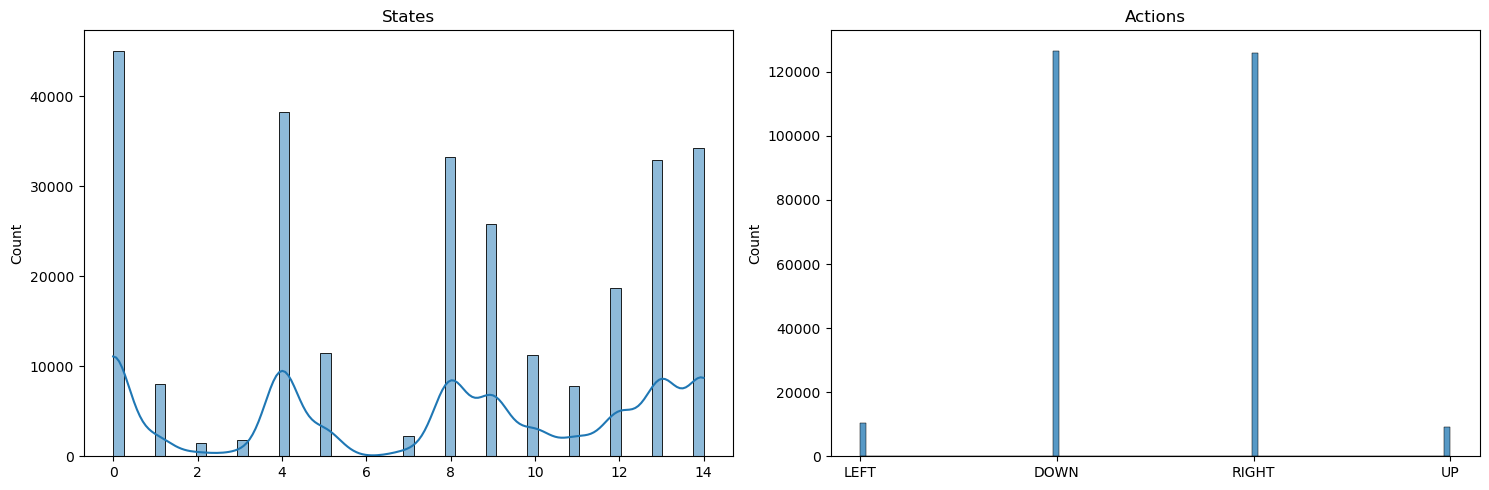

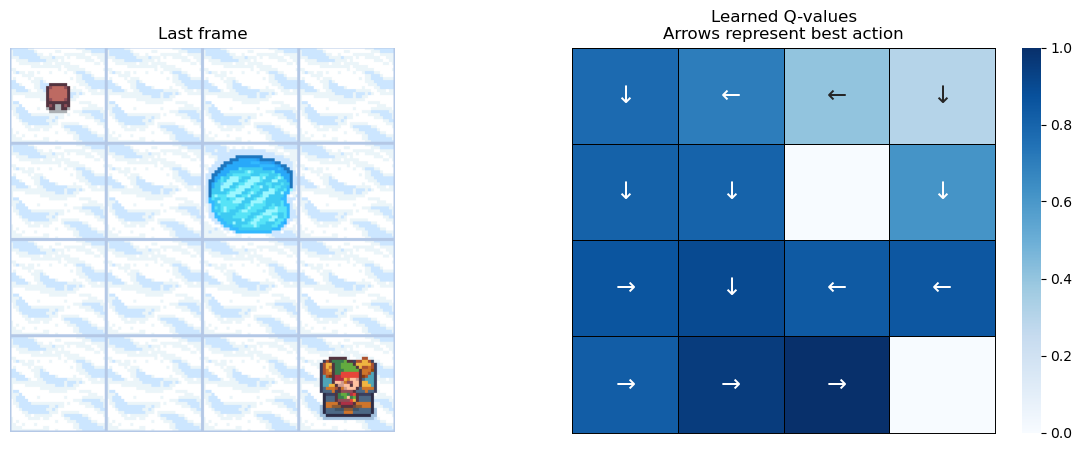

Map size: 7x7


Run 0/20 - Episodes:   0%|                             | 0/2000 [00:00<?, ?it/s]/Users/bhavani/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/Users/bhavani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bhavani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bhavani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

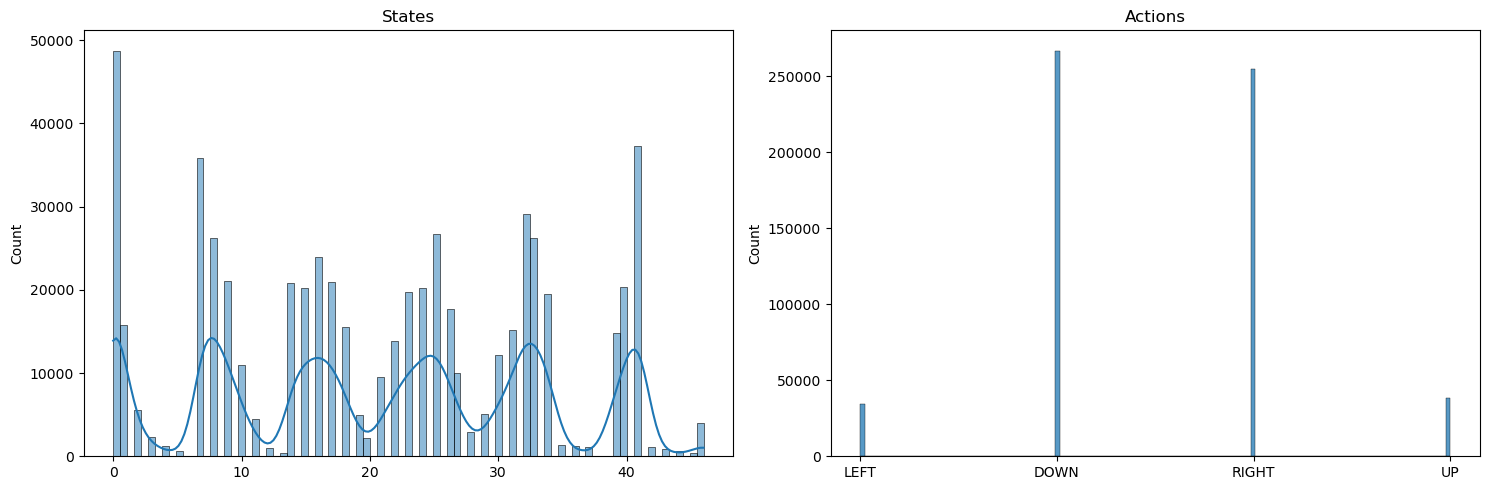

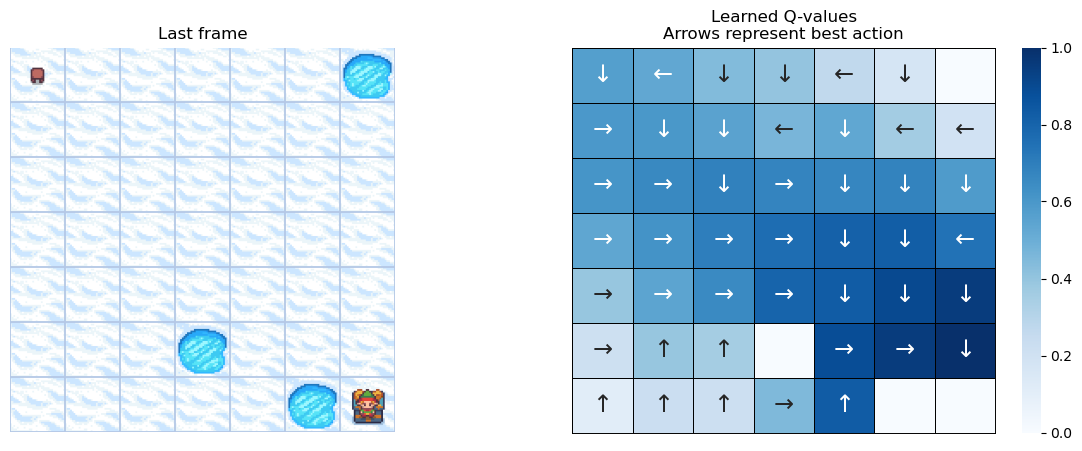

Map size: 9x9


Run 0/20 - Episodes:   0%|                             | 0/2000 [00:00<?, ?it/s]/Users/bhavani/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/Users/bhavani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bhavani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bhavani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

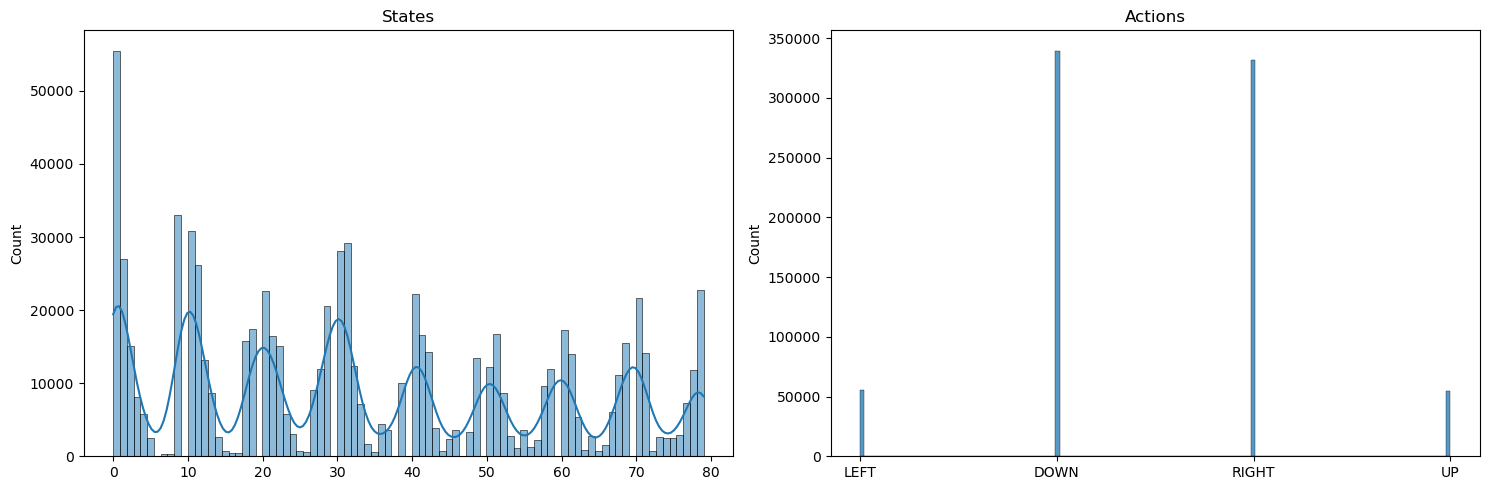

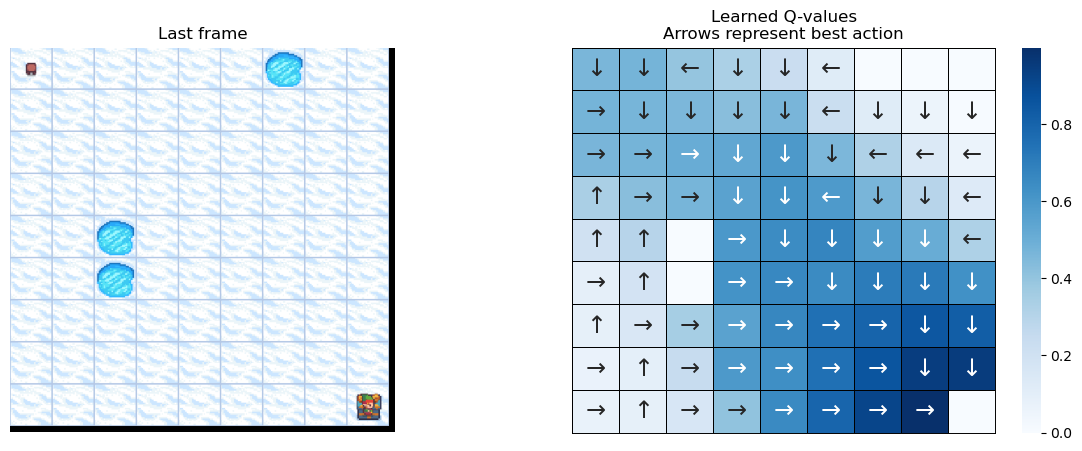

Map size: 11x11


Run 0/20 - Episodes:   0%|                             | 0/2000 [00:00<?, ?it/s]/Users/bhavani/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/Users/bhavani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bhavani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bhavani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

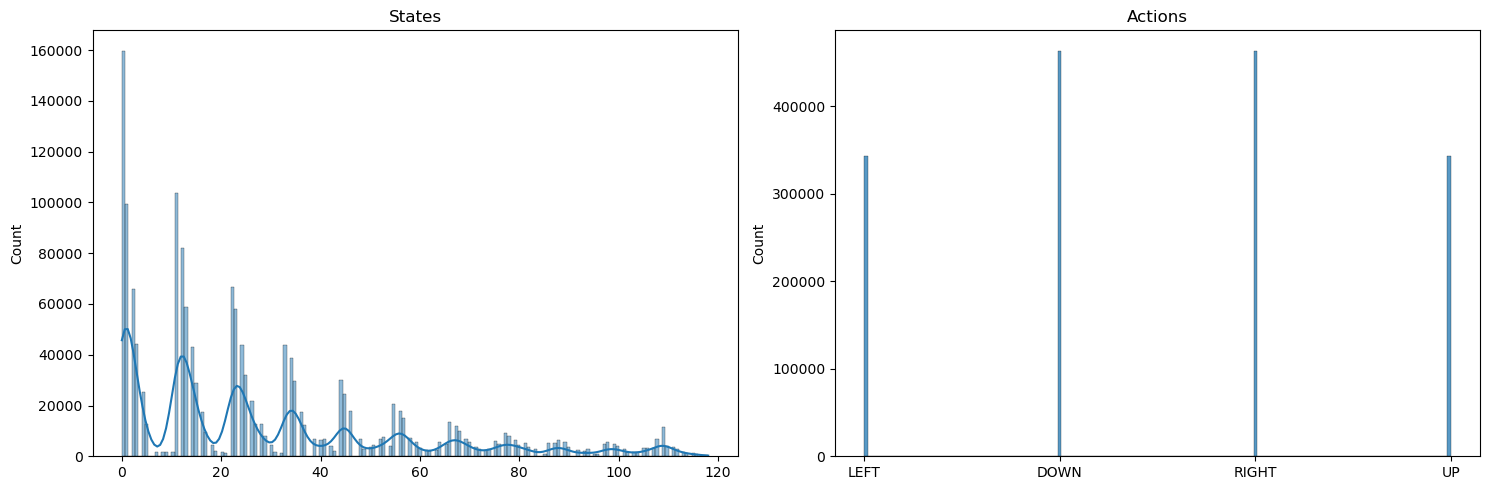

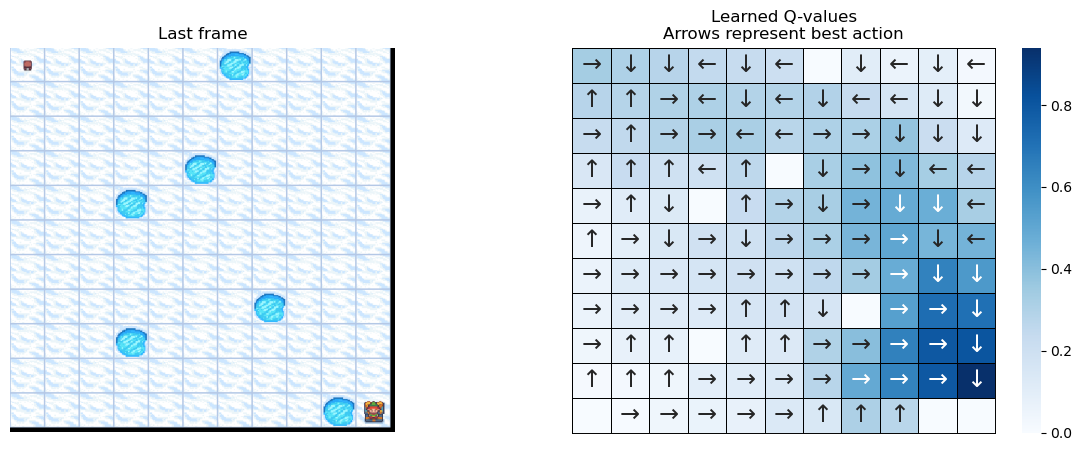

In [12]:
import pandas as pd
import numpy as np

map_sizes = [4, 7, 9, 11]
res_all = pd.DataFrame()
st_all = pd.DataFrame()

for map_size in map_sizes:
    np.random.seed(params.seed)  # Set the seed for reproducibility
    map_desc = generate_random_map(size=map_size, p=params.proba_frozen)
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=map_desc,
    )

    params = params._replace(action_size=env.action_space.n)
    params = params._replace(state_size=env.observation_space.n)
    env.action_space.seed(params.seed)  # Set the seed for reproducible action space sampling

    learner = Qlearning(
        learning_rate=params.learning_rate,
        gamma=params.gamma,
        state_size=params.state_size,
        action_size=params.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=params.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env()

    # Save the results in dataframes
    res, st = postprocess(episodes, params, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)  # Average the Q-table between runs

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )  # Sanity check
    plot_q_values_map(qtable, env, map_size)

    env.close()


The code snippet conducts experiments with Q-learning on the FrozenLake environment across various map sizes. It iterates over different map sizes, runs Q-learning with different parameters for each size, collects and post-processes results, and generates visualizations. This systematic approach allows for the analysis of how map size and Q-learning parameters impact learning performance.

In [13]:
pip install pygame

Note: you may need to restart the kernel to use updated packages.


In [14]:
import warnings

# Suppress DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [3]:
import gym
import numpy as np

# Function to run Q-Learning
def q_learning(env, num_episodes, alpha, gamma, epsilon):
    # Initialize Q table
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    Q = np.zeros((num_states, num_actions))
    
    rewards = []
    
    for episode in range(num_episodes):
        state = env.reset()[0]  # Extract numeric state value
        done = False
        total_reward = 0
        
        while not done:
            # Ensure state is an integer
            state = int(state)
            
            # Exploration-exploitation trade-off
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                action = np.argmax(Q[state, :])  # Exploit
                
            # Take action and observe the next state and reward
            next_state_tuple, reward, done, _ = env.step(action)[:4]  # Unpack the first four values
            
            # Extract numeric next_state value from tuple if next_state_tuple is a tuple
            if isinstance(next_state_tuple, tuple):
                next_state = next_state_tuple[0]
            else:
                next_state = next_state_tuple
            
            # Ensure next_state is an integer
            next_state = int(next_state)
            
            # Update Q table
            Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state, :]) - Q[state, action])
            
            total_reward += reward
            state = next_state
        
        rewards.append(total_reward)
    
    return Q, rewards

# Function to evaluate Q-Learning agent
def evaluate_q_learning(env, Q, num_episodes):
    rewards = []
    
    for _ in range(num_episodes):
        state = env.reset()[0]  # Extract numeric state value
        done = False
        total_reward = 0
        
        while not done:
            # Ensure state is an integer
            state = int(state)
            
            action = np.argmax(Q[state, :])
            next_state_tuple, reward, done, _ = env.step(action)[:4]  # Unpack the first four values
            
            # Extract numeric next_state value from tuple if next_state_tuple is a tuple
            if isinstance(next_state_tuple, tuple):
                next_state = next_state_tuple[0]
            else:
                next_state = next_state_tuple
            
            total_reward += reward
            state = next_state
        
        rewards.append(total_reward)
    
    return rewards

# Frozen Lake environment
env = gym.make("FrozenLake-v1")

# Hyperparameters
num_episodes = 1000
alphas = [0.1, 0.5, 0.9]
gammas = [0.1, 0.5, 0.9]
epsilons = [0.1, 0.5, 0.9]
num_eval_episodes = 100

# Perform Q-Learning with different hyperparameters
for alpha in alphas:
    for gamma in gammas:
        for epsilon in epsilons:
            print("Training with alpha={}, gamma={}, epsilon={}...".format(alpha, gamma, epsilon))
            Q, train_rewards = q_learning(env, num_episodes, alpha, gamma, epsilon)
            eval_rewards = evaluate_q_learning(env, Q, num_eval_episodes)
            avg_train_reward = np.mean(train_rewards)
            avg_eval_reward = np.mean(eval_rewards)
            print("Average training reward: {:.2f}".format(avg_train_reward))
            print("Average evaluation reward: {:.2f}".format(avg_eval_reward))
            print()


Training with alpha=0.1, gamma=0.1, epsilon=0.1...
Average training reward: 0.00
Average evaluation reward: 0.00

Training with alpha=0.1, gamma=0.1, epsilon=0.5...
Average training reward: 0.01
Average evaluation reward: 0.09

Training with alpha=0.1, gamma=0.1, epsilon=0.9...
Average training reward: 0.02
Average evaluation reward: 0.10

Training with alpha=0.1, gamma=0.5, epsilon=0.1...
Average training reward: 0.00
Average evaluation reward: 0.00

Training with alpha=0.1, gamma=0.5, epsilon=0.5...
Average training reward: 0.00
Average evaluation reward: 0.04

Training with alpha=0.1, gamma=0.5, epsilon=0.9...
Average training reward: 0.02
Average evaluation reward: 0.05

Training with alpha=0.1, gamma=0.9, epsilon=0.1...
Average training reward: 0.00
Average evaluation reward: 0.00

Training with alpha=0.1, gamma=0.9, epsilon=0.5...
Average training reward: 0.03
Average evaluation reward: 0.30

Training with alpha=0.1, gamma=0.9, epsilon=0.9...
Average training reward: 0.03
Average

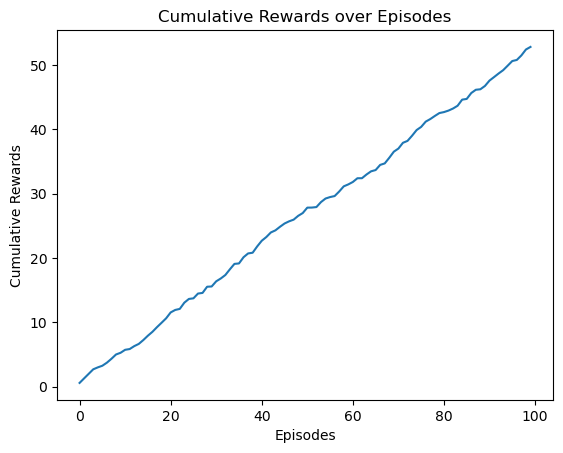

In [16]:
import numpy as np
import matplotlib.pyplot as plt

class MyClass:
    def __init__(self, rewards_per_episode, episodes):
        self.rewards_per_episode = rewards_per_episode
        self.episodes = episodes

    def plot_steps_and_rewards(self, ax):
        sum_rewards = np.cumsum(self.rewards_per_episode[:self.episodes])
        ax.plot(sum_rewards)
        ax.set_title("Cumulative Rewards over Episodes")
        ax.set_xlabel("Episodes")
        ax.set_ylabel("Cumulative Rewards")

# Example usage:
# Instantiate the class
rewards_per_episode = np.random.rand(100)  # Example rewards per episode
episodes = 100
my_instance = MyClass(rewards_per_episode, episodes)

# Create a figure and axis
fig, ax = plt.subplots()
# Call the plot method
my_instance.plot_steps_and_rewards(ax)
# Show the plot
plt.show()


COMMENT : Here's a condensed summary of the output:

Alpha (Learning Rate):
Low alpha (0.1): Low evaluation rewards.
Medium and high alpha (0.5, 0.9): Slightly to generally better rewards.
Gamma (Discount Factor):
Low gamma (0.1): Low rewards, improvement with medium and high gamma.
Medium and high gamma (0.5, 0.9): Generally better rewards.
Epsilon (Exploration Rate):
Low epsilon (0.1): Low rewards, slight improvement with medium and high epsilon.
Medium and high epsilon (0.5, 0.9): Generally better rewards.
Overall, medium values for alpha, gamma, and epsilon tend to yield better rewards, indicating a balanced exploration-exploitation trade-off and consideration of future rewards.

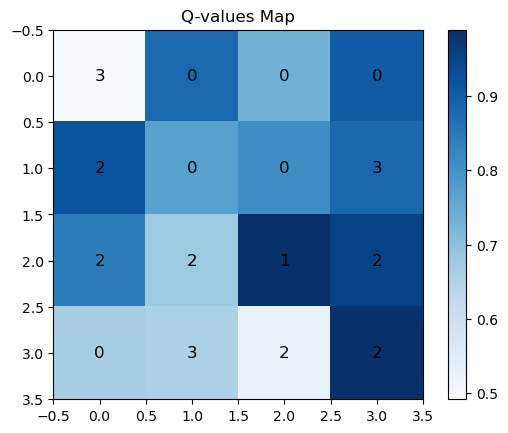

In [17]:
import numpy as np
import matplotlib.pyplot as plt

class MyClass:
    def __init__(self, qArray, game_size):
        self.qArray = qArray
        self.game_size = game_size

    def plot_q_values_map(self, ax):
        q_values = np.max(self.qArray, axis=1).reshape((self.game_size, self.game_size))
        best_actions = np.argmax(self.qArray, axis=1).reshape((self.game_size, self.game_size))

        im = ax.imshow(q_values, cmap='Blues')
        ax.set_title("Q-values Map")
        for i in range(self.game_size):
            for j in range(self.game_size):
                ax.text(j, i, str(best_actions[i, j]), ha='center', va='center', color='black', fontsize=12)
        plt.colorbar(im, ax=ax)

# Example usage:
# Instantiate the class
qArray = np.random.rand(16, 4)  # Example qArray
game_size = 4
my_instance = MyClass(qArray, game_size)

# Create a figure and axis
fig, ax = plt.subplots()
# Call the plot method
my_instance.plot_q_values_map(ax)
# Show the plot
plt.show()


COMMENT : The code defines a class MyClass with a method plot_q_values_map to visualize Q-values and best actions in a grid environment. It takes a Q-values array and the size of the grid as inputs and generates a plot with the Q-values as colors and the best actions as text labels.

In [18]:
pip install gym[atari]


zsh:1: no matches found: gym[atari]
Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install gym[atari,accept-rom-license]==0.21.0

zsh:1: no matches found: gym[atari,accept-rom-license]==0.21.0
Note: you may need to restart the kernel to use updated packages.


In [20]:
import gym

# Get the list of available environments
env_ids = list(gym.envs.registry.keys())

# Print the list of available environments
for env_id in env_ids:
    print(env_id)


ALE/Adventure-v5
ALE/Adventure-ram-v5
ALE/AirRaid-v5
ALE/AirRaid-ram-v5
ALE/Alien-v5
ALE/Alien-ram-v5
ALE/Amidar-v5
ALE/Amidar-ram-v5
ALE/Assault-v5
ALE/Assault-ram-v5
ALE/Asterix-v5
ALE/Asterix-ram-v5
ALE/Asteroids-v5
ALE/Asteroids-ram-v5
ALE/Atlantis-v5
ALE/Atlantis-ram-v5
ALE/Atlantis2-v5
ALE/Atlantis2-ram-v5
ALE/Backgammon-v5
ALE/Backgammon-ram-v5
ALE/BankHeist-v5
ALE/BankHeist-ram-v5
ALE/BasicMath-v5
ALE/BasicMath-ram-v5
ALE/BattleZone-v5
ALE/BattleZone-ram-v5
ALE/BeamRider-v5
ALE/BeamRider-ram-v5
ALE/Berzerk-v5
ALE/Berzerk-ram-v5
ALE/Blackjack-v5
ALE/Blackjack-ram-v5
ALE/Bowling-v5
ALE/Bowling-ram-v5
ALE/Boxing-v5
ALE/Boxing-ram-v5
ALE/Breakout-v5
ALE/Breakout-ram-v5
ALE/Carnival-v5
ALE/Carnival-ram-v5
ALE/Casino-v5
ALE/Casino-ram-v5
ALE/Centipede-v5
ALE/Centipede-ram-v5
ALE/ChopperCommand-v5
ALE/ChopperCommand-ram-v5
ALE/CrazyClimber-v5
ALE/CrazyClimber-ram-v5
ALE/Crossbow-v5
ALE/Crossbow-ram-v5
ALE/Darkchambers-v5
ALE/Darkchambers-ram-v5
ALE/Defender-v5
ALE/Defender-ram-v5
ALE/

In [21]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install 'gym[atari]'

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install 'gym[accept-rom-license]'

Note: you may need to restart the kernel to use updated packages.


In [24]:
import gym
env = gym.make('Breakout-v0')

/Users/bhavani/anaconda3/lib/python3.11/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Breakout-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [2]:
import numpy as np
import gym

class QLearningAgent:
    def __init__(self, action_space_size, observation_space_size, alpha=0.1, gamma=0.99, epsilon=1.0):
        # Initialize Q-learning agent with default parameters
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration-exploitation trade-off
        self.action_space_size = action_space_size
        self.observation_space_size = observation_space_size
        self.num_states = 1000  # Define a fixed number of states for simplicity
        self.q_table = np.zeros((self.num_states, action_space_size))  # Initialize Q-table with zeros

    def preprocess_observation(self, state):
        # Preprocess observation: Resize, convert to grayscale, and flatten
        if isinstance(state, tuple):
            image = state[0]
        else:
            image = state
        state_array = np.array(image)
        resized_state = state_array[::2, ::2, 0]  # Reduce resolution and select only one color channel
        return resized_state.flatten()

    def choose_action(self, state):
        # Choose action based on epsilon-greedy policy
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_space_size)  # Random action
        else:
            return np.argmax(self.q_table[state])  # Greedy action based on Q-values

    def update_q_table(self, state, action, reward, next_state):
        # Update Q-values using Q-learning update rule
        old_value = self.q_table[state][action]
        next_max = np.max(self.q_table[next_state])
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[state][action] = new_value

    def train(self, env, num_episodes):
        # Train the agent using Q-learning
        total_rewards = []  # Store total rewards for each episode
        for episode in range(num_episodes):
            state = env.reset()  # Reset environment
            state = self.preprocess_observation(state)  # Preprocess initial state
            done = False  # Initialize episode completion flag
            total_reward = 0  # Initialize total reward for the episode

            while not done:
                action = self.choose_action(state)  # Choose action
                step_result = env.step(action)  # Take action in the environment
                next_state, reward, done = step_result[:3]  # Extract state, reward, and done flag
                next_state = self.preprocess_observation(next_state)  # Preprocess next state
                self.update_q_table(state, action, reward, next_state)  # Update Q-values
                total_reward += reward  # Accumulate total reward
                state = next_state  # Transition to next state

            total_rewards.append(total_reward)  # Store total reward for the episode
            if (episode + 1) % 5 == 0:
                print("Episode:", episode+1, "Average Reward:", np.mean(total_rewards))  # Print average reward
                total_rewards = []  # Reset total rewards for the next set of episodes

# Create Breakout environment
env = gym.make('Breakout-v0')

# Define agent parameters
num_actions = env.action_space.n  # Number of actions in the environment
observation_space_size = 210*160  # Original resolution of Breakout

# Instantiate Q-learning agent
agent = QLearningAgent(num_actions, observation_space_size)

# Train the agent
num_episodes = 100
agent.train(env, num_episodes)


/Users/bhavani/anaconda3/lib/python3.11/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Breakout-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(


Episode: 5 Average Reward: 0.4
Episode: 10 Average Reward: 0.4
Episode: 15 Average Reward: 1.4
Episode: 20 Average Reward: 2.2
Episode: 25 Average Reward: 2.0
Episode: 30 Average Reward: 1.8
Episode: 35 Average Reward: 1.6
Episode: 40 Average Reward: 0.4
Episode: 45 Average Reward: 1.8
Episode: 50 Average Reward: 0.6
Episode: 55 Average Reward: 2.6
Episode: 60 Average Reward: 1.2
Episode: 65 Average Reward: 1.6
Episode: 70 Average Reward: 2.4
Episode: 75 Average Reward: 0.4
Episode: 80 Average Reward: 0.6
Episode: 85 Average Reward: 1.6
Episode: 90 Average Reward: 2.0
Episode: 95 Average Reward: 1.0
Episode: 100 Average Reward: 2.6


COMMENT : The output displays the average reward per episode at intervals during the training process. Here's a summary of the output:

The agent starts training and prints the average reward every 5 episodes.
Each line in the output represents the episode number and its corresponding average reward.
The output indicates the agent's learning progress over the training episodes.
For example, it shows how the average reward changes as the agent learns to play the Breakout game.
Overall, the output provides insight into the agent's performance and learning trajectory throughout the training process.

# I did these based on above training values

In [1]:
import numpy as np
import gym

class QLBreakoutAgent:
    def __init__(self, action_space_size, observation_space_size, alpha=0.1, gamma=0.99, epsilon=1.0):
        self.alpha = alpha  
        self.gamma = gamma  
        self.epsilon = epsilon  
        self.action_space_size = action_space_size
        self.observation_space_size = observation_space_size
        self.num_states = 1000  # Define a fixed number of states for simplicity
        self.q_table = np.zeros((self.num_states, action_space_size))

    def preprocess_observation(self, state):
        # If state is a tuple, extract the image
        if isinstance(state, tuple):
            image = state[0]
        else:
            image = state
        
        # Convert image to numpy array
        state_array = np.array(image)
        
        # Resize and convert to grayscale
        resized_state = state_array[::2, ::2, 0]  # Reduce resolution and select only one color channel
        return resized_state.flatten()

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_space_size)
        else:
            return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, reward, next_state):
        old_value = self.q_table[state][action]
        next_max = np.max(self.q_table[next_state])
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[state][action] = new_value

    def train(self, env, num_episodes):
        total_rewards = []
        for episode in range(num_episodes):
            state = env.reset()
            state = self.preprocess_observation(state)
            done = False
            total_reward = 0

            while not done:
                action = self.choose_action(state)
                step_result = env.step(action)
                next_state, reward, done = step_result[:3]  # Extract only the first three values
                
                if isinstance(next_state, tuple):
                    next_state = self.preprocess_observation(next_state[0])
                else:
                    next_state = self.preprocess_observation(next_state)
                self.update_q_table(state, action, reward, next_state)
                total_reward += reward
                state = next_state

            total_rewards.append(total_reward)
            if (episode + 1) % 20 == 0:
                print("Episode:", episode+1, "Average Reward:", np.mean(total_rewards))
                total_rewards = []

# Create Breakout environment
env = gym.make('Breakout-v0')

# Define agent parameters
action_space_size = env.action_space.n
observation_space_size = 210*160  # Original resolution of Breakout

# Define sets of parameters
alphas = [0.1, 0.5, 0.9]
gammas = [0.1, 0.5, 0.9]
epsilons = [0.1, 0.5, 0.9]

# Train the agents with different parameters
for alpha in alphas:
    for gamma in gammas:
        for epsilon in epsilons:
            agent = QLBreakoutAgent(action_space_size, observation_space_size, alpha, gamma, epsilon)
            print(f"Training with alpha={alpha}, gamma={gamma}, epsilon={epsilon}")
            agent.train(env, num_episodes=100)


/Users/bhavani/anaconda3/lib/python3.11/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Breakout-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/Users/bhavani/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Training with alpha=0.1, gamma=0.1, epsilon=0.1
Episode: 20 Average Reward: 1.5
Episode: 40 Average Reward: 0.55
Episode: 60 Average Reward: 1.3
Episode: 80 Average Reward: 1.0
Episode: 100 Average Reward: 1.45
Training with alpha=0.1, gamma=0.1, epsilon=0.5
Episode: 20 Average Reward: 1.75
Episode: 40 Average Reward: 1.1
Episode: 60 Average Reward: 1.0
Episode: 80 Average Reward: 0.8
Episode: 100 Average Reward: 1.5
Training with alpha=0.1, gamma=0.1, epsilon=0.9
Episode: 20 Average Reward: 0.9
Episode: 40 Average Reward: 1.2
Episode: 60 Average Reward: 1.15
Episode: 80 Average Reward: 0.9
Episode: 100 Average Reward: 1.4
Training with alpha=0.1, gamma=0.5, epsilon=0.1
Episode: 20 Average Reward: 1.15
Episode: 40 Average Reward: 0.85
Episode: 60 Average Reward: 1.45
Episode: 80 Average Reward: 1.6
Episode: 100 Average Reward: 0.75
Training with alpha=0.1, gamma=0.5, epsilon=0.5
Episode: 20 Average Reward: 1.45
Episode: 40 Average Reward: 1.75
Episode: 60 Average Reward: 1.15
Episode: 

The code trains Q-learning agents with different combinations of alpha, gamma, and epsilon values on the Breakout environment. Here's a small summary:

Three different values are tested for each of the hyperparameters alpha, gamma, and epsilon: [0.1, 0.5, 0.9].
The training process prints the average reward every 20 episodes for each combination of hyperparameters.
Each combination of hyperparameters is trained for 100 episodes.
By iterating through all combinations, the code evaluates the performance of the Q-learning agent with different parameter settings.
After training, the code provides insight into how different combinations of hyperparameters affect the learning process and the resulting agent's performance.
Overall, this approach systematically explores the impact of different hyperparameter settings on the Q-learning agent's training process and performance.